# Программирование и компьютерные науки, ФИКЛ ВШЭ

## Домашнее задание №7

## Общая информация

### О задании

Задание состоит из двух разделов:
1. В первом разделе Вы научитесь применять деревья из sklearn для задачи классификации.
2. Во втором разделе Вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn.
 
### Оценивание
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя, если Вы заранее не предупредите об этом преподавателя и не предоставите на то уважительную причину.

В этом задании не требуeтся эффективная реализация кода дерева. Можете не переживать за это, снижать оценку за "долго работающий код" не буду. Главное, чтобы Ваш алгоритм мог показать адекватное качество!


### Формат сдачи
Задание сдается аналогично HW5 через гугл-форму.



In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Sklearn.

В этой части мы рассмотрим работу решающего дерева из пакета sklearn. Для этого мы сами сгенерируем датасет:

In [22]:
from sklearn.datasets import make_moons, make_circles, make_classification


dataset = make_moons(noise=0.2, random_state=42)

Посмотрим, как выглядят наши данные:

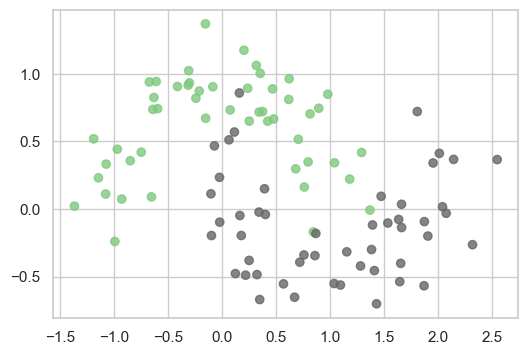

In [23]:
plt.figure(figsize=(6, 4))
x, y = dataset
plt.scatter(x[:, 0], x[:, 1], c=y, alpha=.8, cmap='Accent')

__Задание 1. (1 балл)__

Давайте теперь обучим дефолтный алгоритм решающего дерева. Для этого разбейте датасет на обучение и тест и обучите модель. Измерьте точность предсказаний при помощи `accuracy`

In [24]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ Разбиваем выборку
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_moons
dataset = make_moons(noise=0.2, random_state=42)
X, y = dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ Обучаем модель
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [26]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ Ваша точность на обучении и тесте
train_accuracy = tree_clf.score(X_train, y_train)
test_accuracy = tree_clf.score(X_test, y_test)
print(f'Train accuracy: {train_accuracy}, Test accuracy: {test_accuracy}')

Train accuracy: 1.0, Test accuracy: 0.8666666666666667


__Задание 2. (1 балл)__

Попробуйте перебрать несколько параметров для улучшения качества дерева (напр. `max_depth`, `min_samples_leaf`, `criterion`). Cоздайте сетку [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) в которой Вы перебираете все возможные комбинации для гиперпараметров. Не создавайте слишком большую сетку, критериев у Вас может быть 2, а `max_depth` и `min_samples_leaf` сделайте по 5 значений на каждый гиперпараметр.

Найдите лучшую модель и выведите ее точность.

In [27]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ Ваш гридсерч
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [28]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ Точность лучшей модели
best_train_accuracy = best_model.score(X_train, y_train)
best_test_accuracy = best_model.score(X_test, y_test)
print(f'Best train accuracy: {best_train_accuracy}, Best test accuracy: {best_test_accuracy}')

Best train accuracy: 0.9857142857142858, Best test accuracy: 0.7666666666666667


Лучше ли модель с дефолтными гиперпараметрами найденной через гридсерч?

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации. В качестве критерия информативности используем индекс Джини:

__Задание 3. (1 балл)__

Реализуйте функцию `gini_index` в которой Вы по данной на вход выборке расчитываете индекс Джини

In [29]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ Ваша функция для индекса Джини
def gini_index(y):
    classes = np.unique(y)
    gini = 1.0
    for cls in classes:
        p = len(y[y == cls]) / len(y)
        gini -= p ** 2
    return gini


__Задание 4. (1 балл)__

Теперь нам нужно реализовать функцию `information_gain`:

![Info](https://tutswiki.com/images/ml/info-gain.png)

Данная функция принимает на вход датафрейм с признаками (`Х`), имя переменной по которой происходит разбиение (`name`), вектор целевой (`у`) переменной и порог по которому нужно проводить разбиение выборки. Вам нужно разбить `Х` и `у` на 2 подвыборки по нужному порогу. После этого Вы рассчитываете индекс Джини по каждой подвыборке (`y_left`, `y_right`) и индекс исходной выборки, и находите взвешенную разницу. После этого Вы должны вернуть: `X_left`, `X_right`, `y_left`, `y_right`, `delta` - признаки и целевые переменные в левой и правой подвыборках и разницу в критериях.

In [30]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ Ваша функция для Information Gain
def information_gain(X, y, feature, threshold):
    left_mask = X[feature] <= threshold
    right_mask = X[feature] > threshold
    y_left, y_right = y[left_mask], y[right_mask]
    if len(y_left) == 0 or len(y_right) == 0:
        return None, None, None, None, -np.inf
    gini_parent = gini_index(y)
    gini_left = gini_index(y_left)
    gini_right = gini_index(y_right)
    n_left, n_right = len(y_left), len(y_right)
    n_total = len(y)
    delta_gini = gini_parent - (n_left / n_total) * gini_left - (n_right / n_total) * gini_right
    return X[left_mask], X[right_mask], y_left, y_right, delta_gini


__Задание 5. (1 балл)__

Теперь необходимо реализовать функцию для поиска лучшего разбиения - `best_split`. Эта функция принимает на вход только признаки (`X`) и целевую переменную (`y`) и должна вернуть `X_left`, `X_right`, `y_left`, `y_right`, `name`, `threshold` - наилучшее разбиение среди всех возможных, а также название признака и порог, по которому получилось это разбиение.

Можете искать лучшее разбиение в цикле - перебирая все признаки и их значения в качестве аргументов для функции `information_gain` и запоминая то разбиение, у которого `delta` наибольшая.

In [31]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ Ваша функция для Best Split
def best_split(X, y):
    best_feature = None
    best_threshold = None
    best_gain = -np.inf
    best_splits = None
    for feature in X.columns:
        thresholds = X[feature].unique()
        for threshold in thresholds:
            X_left, X_right, y_left, y_right, delta_gini = information_gain(X, y, feature, threshold)
            if delta_gini is not None and delta_gini > best_gain:
                best_feature = feature
                best_threshold = threshold
                best_gain = delta_gini
                best_splits = (X_left, X_right, y_left, y_right)
    if best_splits is None:
        return None, None, None, None, None, None
    return *best_splits, best_feature, best_threshold


__Задание 6. (3 балла).__

Теперь мы готовы собрать все ингридиенты вместе! Давайте все завернем в класс `DecisionTree`. Для решения задачи нам нужно 3 метода - конструктор класса, метод `fit` и метод `predict`. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Также сравните точность Вашего дерева и реализации sklearn.


Самой сложной частью всего ДЗ является реализация метода `fit`. Вам нужно подумать над несколькими моментами:

* Как проверять критерий останова?
* Как хранить предикаты для их дальнейшего использования в `predict`?
* Как правильно строить дерево?
* Как хранить листы?

Если Вы успешно сделали предыдущие пункты, то уже умеете искать оптимальное разбиение, а также запоминать предикат этого разбиения. Теперь необходимо организовать это все вместе. Возможно, Вы придумаете способ запоминать предикаты и листы неявно, способов реализации может быть много.

Также, Вам не обязательно реализовывать гиперпараметры (напр. `max_depth`, `min_samples_leaf`, `criterion`).

In [32]:
class DecisionTree:

    def __init__(self):
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y):
        if len(np.unique(y)) == 1:
            return {'label': y.iloc[0]}
        if len(X.columns) == 0:
            return {'label': y.mode().iloc[0]}
        X_left, X_right, y_left, y_right, feature, threshold = best_split(X, y)
        if feature is None:
            return {'label': y.mode().iloc[0]}
        return {
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X_left, y_left),
            'right': self._build_tree(X_right, y_right)
        }

    def predict(self, X):
        return X.apply(self._predict_one, axis=1)

    def _predict_one(self, x):
        node = self.tree
        while 'label' not in node:
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['label']

# Тестирование класса DecisionTree
X_df = pd.DataFrame(X, columns=['x1', 'x2'])
dt = DecisionTree()
dt.fit(X_df, pd.Series(y))
predictions = dt.predict(X_df)
accuracy = (predictions == y).mean()
print(f'Accuracy: {accuracy}')



Accuracy: 1.0


In [33]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ Сравние точность
# Сравнение с sklearn
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
sklearn_accuracy = tree_clf.score(X_test, y_test)
print(f'Sklearn accuracy: {sklearn_accuracy}')

Sklearn accuracy: 0.8666666666666667


__Задание 7. (1 балл).__

Отлично! Разобравшись с одним деревом, мы захотим построить ансамблевую модель! Как правило, одно дерево не используют для решения задачи, а строят над ними ансамбль - либо бэггинг, либо бустинг, либо случайный лес. Сейчас мы попробуем посмотреть разницу в этих алгоритмах. Используем реализации леса и бустинга из sklearn.

Выполните следующие шаги:

1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
2. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
 - DecisionTreeClassifier
 - BaggingClassifier со 100 деревьями
 - BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
 - RandomForestClassifier со 100 деревьями
 - RandomForestClassifier с 1000 деревьями
 - RandomForestClassifier с 5000 деревьями (код будет работать долго)

Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами.

In [34]:
wine_data = pd.read_csv('winequality-red.csv', delimiter=';')
X_wine = wine_data.iloc[:, :-1]
y_wine = wine_data.iloc[:, -1]

# DecisionTreeClassifier
tree_scores = cross_val_score(DecisionTreeClassifier(), X_wine, y_wine, cv=3, scoring='accuracy')
print(f'DecisionTreeClassifier: {tree_scores.mean()}')

# BaggingClassifier со 100 деревьями
bagging_clf_100 = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=42)
bagging_scores_100 = cross_val_score(bagging_clf_100, X_wine, y_wine, cv=3, scoring='accuracy')
print(f'BaggingClassifier со 100 деревьями: {bagging_scores_100.mean()}')

# BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков
bagging_clf_100_half_features = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_features=0.5, random_state=42)
bagging_scores_100_half_features = cross_val_score(bagging_clf_100_half_features, X_wine, y_wine, cv=3, scoring='accuracy')
print(f'BaggingClassifier (100 деревьев, половина функций): {bagging_scores_100_half_features.mean()}')

# RandomForestClassifier со 100 деревьями
rf_clf_100 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores_100 = cross_val_score(rf_clf_100, X_wine, y_wine, cv=3, scoring='accuracy')
print(f'RandomForestClassifier со 100 деревьями: {rf_scores_100.mean()}')

# RandomForestClassifier с 1000 деревьями
rf_clf_1000 = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_scores_1000 = cross_val_score(rf_clf_1000, X_wine, y_wine, cv=3, scoring='accuracy')
print(f'RandomForestClassifier с 1000 деревьями: {rf_scores_1000.mean()}')

# RandomForestClassifier с 5000 деревьями
rf_clf_5000 = RandomForestClassifier(n_estimators=5000, random_state=42)
rf_scores_5000 = cross_val_score(rf_clf_5000, X_wine, y_wine, cv=3, scoring='accuracy')
print(f'RandomForestClassifier с 5000 деревьями: {rf_scores_5000.mean()}')

DecisionTreeClassifier: 0.4546591619762352
BaggingClassifier (100 trees): 0.5603502188868044
BaggingClassifier (100 trees, half features): 0.5540963101938711
RandomForestClassifier (100 trees): 0.5622263914946842
RandomForestClassifier (1000 trees): 0.5653533458411507
RandomForestClassifier (5000 trees): 0.5603502188868043


__Задание 8. (1 балл).__

Продолжим работать с набором данных winequality-red.csv. Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Теперь будем обучать градиентный бустинг из того же sklearn (GradientBoostingClassifier). Обучите 3 бустинга - с 100, 1000 и 5000 деревьями. Посчитайте accuracy на тестовой выборке для каждого числа деревьев.

Код будет работать долго!

Ответьте на вопрос. Переобучается ли случайный лес и бустинг с увеличением числа деревьев?

In [36]:
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, test_size=0.3, random_state=42)

# GradientBoostingClassifier с 100 деревьями
gb_clf_100 = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf_100.fit(X_train_wine, y_train_wine)
gb_accuracy_100 = gb_clf_100.score(X_test_wine, y_test_wine)
print(f'GradientBoostingClassifier (100 деревьев): {gb_accuracy_100}')

# GradientBoostingClassifier с 1000 деревьями
gb_clf_1000 = GradientBoostingClassifier(n_estimators=1000, random_state=42)
gb_clf_1000.fit(X_train_wine, y_train_wine)
gb_accuracy_1000 = gb_clf_1000.score(X_test_wine, y_test_wine)
print(f'GradientBoostingClassifier (1000 деревьев): {gb_accuracy_1000}')

# GradientBoostingClassifier с 5000 деревьями
gb_clf_5000 = GradientBoostingClassifier(n_estimators=5000, random_state=42)
gb_clf_5000.fit(X_train_wine, y_train_wine)
gb_accuracy_5000 = gb_clf_5000.score(X_test_wine, y_test_wine)
print(f'GradientBoostingClassifier (5000 деревьев): {gb_accuracy_5000}')

GradientBoostingClassifier (100 trees): 0.63125
GradientBoostingClassifier (1000 trees): 0.6354166666666666
GradientBoostingClassifier (5000 trees): 0.6166666666666667


Вставьте что угодно, описывающее ваши впечатления от этого задания: